In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mlmicrophysics.explain import feature_importance, feature_importance_column, partial_dependence_1d, partial_dependence_2d
from mlsurfacelayer.derived import obukhov_length
%matplotlib inline

In [2]:
data = pd.read_csv("/Users/dgagne/data/cabauw_derived_data.csv", index_col="Time", parse_dates=["Time"])
data = data.dropna()

In [3]:
data["log friction velocity"] = np.log10(data["friction velocity_surface_m s-1"])
data["log wind speed_10 m_m s-1"] = np.log10(np.maximum(data["wind speed_10 m_m s-1"], 0.01))

In [4]:
data["roughness length_surface_m"] = np.minimum(9, np.maximum(0.001, 10 * np.exp(-0.4 * np.maximum(data["wind speed_10 m_m s-1"], 1) / data["friction velocity_surface_m s-1"])))

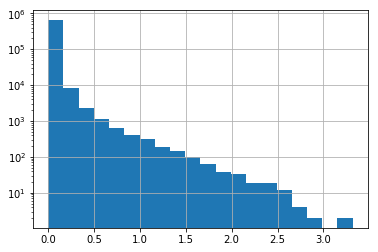

In [5]:
data["roughness length_surface_m"].hist(bins=20)
plt.gca().set_yscale("log")


In [5]:
split_date = pd.Timestamp("2011-01-01")
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

In [4]:
data.columns

Index(['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees', 'temperature_10 m_K', 'temperature_2 m_K',
       'pressure_2 m_hPa', 'potential temperature_10 m_K',
       'potential temperature_2 m_K', 'mixing ratio_10 m_g kg-1',
       'relative humidity_10 m_%', 'virtual potential temperature_10 m_K',
       'air density_10 m_kg m-3', 'wind speed_10 m_m s-1',
       'wind direction_10 m_m s-1', 'wind speed_20 m_m s-1',
       'wind direction_20 m_m s-1', 'wind speed_40 m_m s-1',
       'wind direction_40 m_m s-1', 'u wind_10 m_m s-1', 'v wind_10 m_m s-1',
       'u wind_20 m_m s-1', 'v wind_20 m_m s-1', 'u wind_40 m_m s-1',
       'v wind_40 m_m s-1', 'mixing ratio_2 m_g kg-1',
       'virtual potential temperature_2 m_K', 'relative humidity_2 m_%',
       'soil temperature_0 cm_K', 'soil temperature_4 cm_K',
       'soil potential temperature_0 cm_K',
       'soil potential temperature_4 cm_K', 'soil water content_3 cm_m3 m-3',
       'soil wat

# Friction Velocity
Compare random forest predicting log of friction velocity with raw value.

In [6]:
input_cols = ['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees',
       'pressure_2 m_hPa', 'potential temperature_10 m_K',
       'potential temperature_2 m_K', 'mixing ratio_10 m_g kg-1',
       'relative humidity_10 m_%',
       'air density_10 m_kg m-3', 'wind speed_10 m_m s-1',
       'wind speed_20 m_m s-1',
       'wind speed_40 m_m s-1',
       'mixing ratio_2 m_g kg-1',
       'relative humidity_2 m_%', 'bulk richardson_10-2 m_']
output_col_1 = 'friction velocity_surface_m s-1'
output_col_2 = "log friction velocity"

In [8]:
rf_1 = RandomForestRegressor(n_estimators=50, n_jobs=4, max_features="sqrt")
rf_1.fit(train_data[input_cols], train_data[output_col_1])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [9]:
rf_1_rankings = np.argsort(rf_1.feature_importances_)[::-1]
for f in rf_1_rankings:
    print(input_cols[f], rf_1.feature_importances_[f])

log wind speed_10 m_m s-1 0.2462710051501118
wind speed_20 m_m s-1 0.17162165229346177
wind speed_10 m_m s-1 0.1610220746868927
wind speed_40 m_m s-1 0.0915395340909169
bulk richardson_10-2 m_ 0.08116312167148608
u wind_10 m_m s-1 0.051437257263268525
u wind_20 m_m s-1 0.03355602655839025
v wind_10 m_m s-1 0.029516453556272124
u wind_40 m_m s-1 0.019933568936117706
zenith_0 m_degrees 0.014212836211695773
global horizontal irradiance_0 m_W m-2 0.013833547151868353
v wind_20 m_m s-1 0.010158400522857311
v wind_40 m_m s-1 0.010037075445835533
potential temperature_2 m_K 0.007656067651923432
relative humidity_2 m_% 0.007418409287696698
potential temperature_10 m_K 0.0068398622120310025
relative humidity_10 m_% 0.006341414520927046
air density_10 m_kg m-3 0.005841248346074188
pressure_2 m_hPa 0.005746414904747497
mixing ratio_2 m_g kg-1 0.005536640169624352
mixing ratio_10 m_g kg-1 0.004853480845101602
azimuth_0 m_degrees 0.004107666759345334
wind direction_40 m_m s-1 0.004005131228612999
w

In [12]:
pfi_scores = feature_importance(train_data[input_cols].values, train_data[output_col_1].values, 
                   rf_1, mean_absolute_error, x_columns=input_cols, permutations=1, processes=1)

0.010735961040972714


In [20]:
pfi_scores.sort_values(by=0) / 0.010735961040972714

,0
log wind speed_10 m_m s-1,-3.440318
wind speed_10 m_m s-1,-2.464003
bulk richardson_10-2 m_,-2.210210
wind speed_20 m_m s-1,-2.116448
wind speed_40 m_m s-1,-1.175992
zenith_0 m_degrees,-0.825363
u wind_10 m_m s-1,-0.771134
potential temperature_2 m_K,-0.673480
global horizontal irradiance_0 m_W m-2,-0.647035
potential temperature_10 m_K,-0.608628


In [10]:
feature_importance_column(train_data[input_cols].values, train_data[output_col_1].values, 
                          1, 0, rf_1, mean_absolute_error, 2323)

(1, 0, 0.01962105417093681)

In [21]:
rf_2 = RandomForestRegressor(n_estimators=50, n_jobs=4, max_features="sqrt")
rf_2.fit(train_data[input_cols], train_data[output_col_2])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
rf_2_rankings = np.argsort(rf_2.feature_importances_)[::-1]
for f in rf_2_rankings:
    print(input_cols[f], rf_2.feature_importances_[f])

bulk richardson_10-2 m_ 0.23521003079206187
log wind speed_10 m_m s-1 0.21875663112040492
wind speed_10 m_m s-1 0.1676451422111429
wind speed_20 m_m s-1 0.07105082480805065
wind speed_40 m_m s-1 0.05450780264540098
u wind_10 m_m s-1 0.033400049225169016
u wind_20 m_m s-1 0.02603736119473646
v wind_10 m_m s-1 0.025917620383312953
zenith_0 m_degrees 0.02565186674381489
global horizontal irradiance_0 m_W m-2 0.023095695680240138
u wind_40 m_m s-1 0.02135912432427481
v wind_20 m_m s-1 0.01805378072104078
potential temperature_2 m_K 0.008420955230061686
v wind_40 m_m s-1 0.007813076610558703
relative humidity_2 m_% 0.007321078573553852
relative humidity_10 m_% 0.006858330654743697
pressure_2 m_hPa 0.006264703900238421
air density_10 m_kg m-3 0.006198316833971365
mixing ratio_2 m_g kg-1 0.0058033777434188605
potential temperature_10 m_K 0.005718297642471455
azimuth_0 m_degrees 0.005699584313568413
mixing ratio_10 m_g kg-1 0.005480598571355086
wind direction_40 m_m s-1 0.004847746612506243
wi

In [9]:
rf_1_preds = rf_1.predict(test_data[input_cols])
#rf_2_preds = 10 ** rf_2.predict(test_data[input_cols])

In [73]:
phi_m = 0.4 / rf_1_preds * test_data["wind speed_10 m_m s-1"]
phi_h = 0.4 / rf_t_scale_preds * (test_data["potential temperature_10 m_K"] - test_data["potential temperature_2 m_K"])
ol = obukhov_length(test_data["potential temperature_10 m_K"], rf_t_scale_preds, rf_1_preds)

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  1., nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan,  1.,  1., ...,  2., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [ 1., nan, nan, ..., nan, nan, nan]]),
 array([-10.        ,  -9.59183673,  -9.18367347,  -8.7755102 ,
         -8.36734694,  -7.95918367,  -7.55102041,  -7.14285714,
         -6.73469388,  -6.32653061,  -5.91836735,  -5.51020408,
         -5.10204082,  -4.69387755,  -4.28571429,  -3.87755102,
         -3.46938776,  -3.06122449,  -2.65306122,  -2.24489796,
         -1.83673469,  -1.42857143,  -1.02040816,  -0.6122449 ,
         -0.20408163,   0.20408163,   0.6122449 ,   1.02040816,
          1.42857143,   1.83673469,   2.24489796,   2.65306122,
          3.06122449,   3.46938776,   3.87755102,   4.28571429,
          4.69387755,   5.10204082,   5.51020408,   5.91836735,
          6.32653061,   6.73469388,   7.14285714,   7.55102041,
          7

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


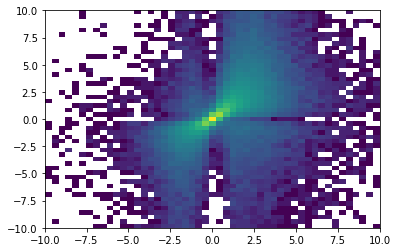

In [87]:
plt.hist2d(10 / ol, 10/ test_data["obukhov length_surface_m"], cmin=1, bins=np.linspace(-10, 10, 50), norm=LogNorm())

(-1, 1)

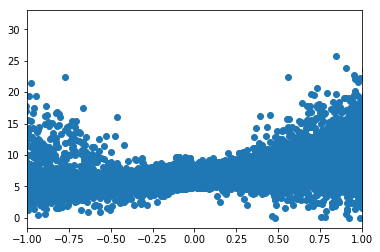

In [77]:
plt.scatter(10 / ol, phi_m)
#plt.scatter(10 / ol, phi_m)

plt.xlim(-1, 1)

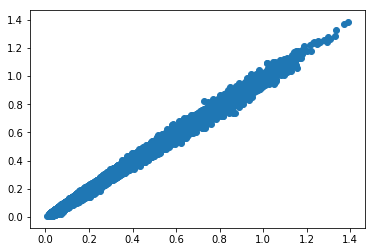

In [24]:
plt.scatter(rf_1_preds, rf_2_preds)

In [26]:
test_data[input_cols].columns

Index(['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees', 'pressure_2 m_hPa',
       'potential temperature_10 m_K', 'potential temperature_2 m_K',
       'mixing ratio_10 m_g kg-1', 'relative humidity_10 m_%',
       'air density_10 m_kg m-3', 'wind speed_10 m_m s-1',
       'wind direction_10 m_m s-1', 'wind speed_20 m_m s-1',
       'wind direction_20 m_m s-1', 'wind speed_40 m_m s-1',
       'wind direction_40 m_m s-1', 'u wind_10 m_m s-1', 'v wind_10 m_m s-1',
       'u wind_20 m_m s-1', 'v wind_20 m_m s-1', 'u wind_40 m_m s-1',
       'v wind_40 m_m s-1', 'mixing ratio_2 m_g kg-1',
       'relative humidity_2 m_%', 'bulk richardson_10-2 m_',
       'log wind speed_10 m_m s-1'],
      dtype='object')

In [27]:
for i in range(len(input_cols)):
    print(i, input_cols[i])

0 global horizontal irradiance_0 m_W m-2
1 zenith_0 m_degrees
2 azimuth_0 m_degrees
3 pressure_2 m_hPa
4 potential temperature_10 m_K
5 potential temperature_2 m_K
6 mixing ratio_10 m_g kg-1
7 relative humidity_10 m_%
8 air density_10 m_kg m-3
9 wind speed_10 m_m s-1
10 wind direction_10 m_m s-1
11 wind speed_20 m_m s-1
12 wind direction_20 m_m s-1
13 wind speed_40 m_m s-1
14 wind direction_40 m_m s-1
15 u wind_10 m_m s-1
16 v wind_10 m_m s-1
17 u wind_20 m_m s-1
18 v wind_20 m_m s-1
19 u wind_40 m_m s-1
20 v wind_40 m_m s-1
21 mixing ratio_2 m_g kg-1
22 relative humidity_2 m_%
23 bulk richardson_10-2 m_
24 log wind speed_10 m_m s-1


(array([4.7008e+04, 9.6547e+04, 6.2874e+04, 2.9305e+04, 1.1514e+04,
        4.0220e+03, 1.3360e+03, 5.8000e+02, 1.2100e+02, 1.1000e+01]),
 array([ 0.   ,  2.074,  4.148,  6.222,  8.296, 10.37 , 12.444, 14.518,
        16.592, 18.666, 20.74 ]),
 <a list of 10 Patch objects>)

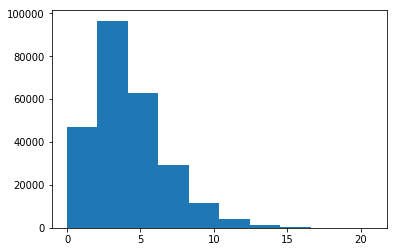

In [15]:
plt.hist(test_data[input_cols].iloc[:, 9])

In [23]:
pd_bins = np.zeros((len(input_cols), 20))
pd_vals = np.zeros((len(input_cols), 19))
pd_counts = np.zeros((len(input_cols), 19))
for i, input_col in enumerate(input_cols):
    print(input_col)
    pd_bins[i] = np.linspace(test_data[input_col].min(), test_data[input_col].max(), 20)
    pd_vals[i], pd_counts[i] = partial_dependence_1d(test_data[input_cols].values, 
                                  rf_1_preds, i, pd_bins[i])

global horizontal irradiance_0 m_W m-2
zenith_0 m_degrees
azimuth_0 m_degrees
pressure_2 m_hPa
potential temperature_10 m_K
potential temperature_2 m_K
mixing ratio_10 m_g kg-1
relative humidity_10 m_%
air density_10 m_kg m-3
wind speed_10 m_m s-1
wind direction_10 m_m s-1
wind speed_20 m_m s-1
wind direction_20 m_m s-1
wind speed_40 m_m s-1
wind direction_40 m_m s-1
u wind_10 m_m s-1
v wind_10 m_m s-1
u wind_20 m_m s-1
v wind_20 m_m s-1
u wind_40 m_m s-1
v wind_40 m_m s-1
mixing ratio_2 m_g kg-1
relative humidity_2 m_%
bulk richardson_10-2 m_
log wind speed_10 m_m s-1


In [67]:
train_data["global horizontal irradiance_0 m_W m-2"].max()

1087.9395

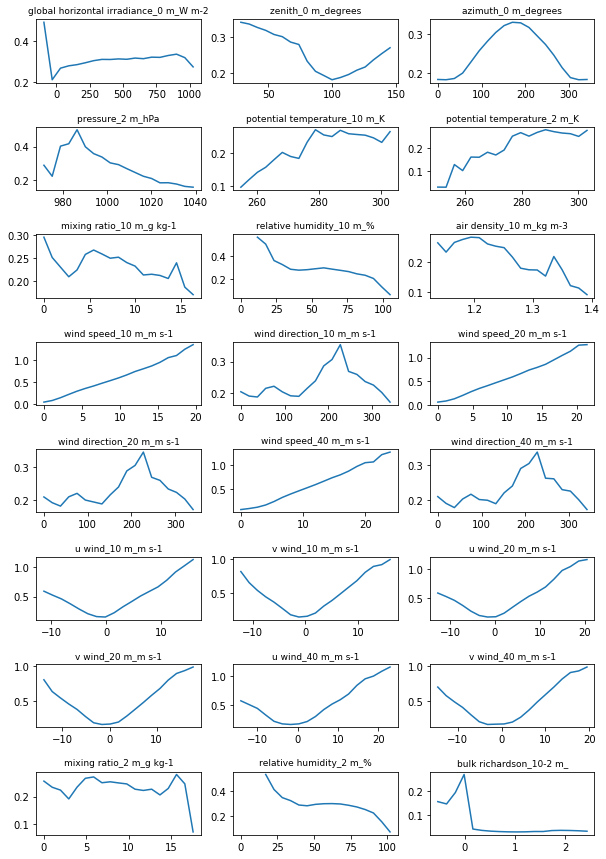

In [65]:
fig, axes = plt.subplots(8, 3, figsize=(10, 15), sharey=False)
plt.subplots_adjust(hspace=0.7, wspace=0.2)
for a, ax in enumerate(axes.ravel()):
    ax.plot(pd_bins[a,:-1], pd_vals[a])
    #ax.plot(pd_bins[a,:-1], pd_counts[a] / pd_counts[a].sum())
    ax.set_title(input_cols[a], fontsize=9)

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


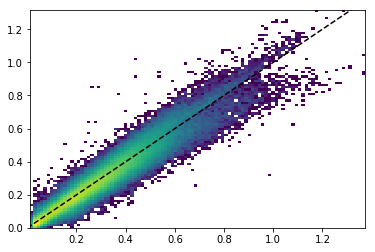

In [16]:
plt.hist2d(rf_1_preds, test_data[output_col_1], bins=100, cmin=1, norm=LogNorm())
plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


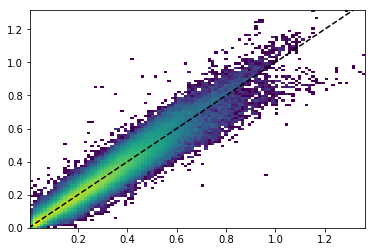

In [17]:
plt.hist2d(rf_2_preds, test_data[output_col_1], bins=100, cmin=1, norm=LogNorm())
plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')

In [18]:
print(mean_absolute_error(test_data[output_col_1], rf_1_preds))
print(r2_score(test_data[output_col_1], rf_1_preds))

0.03050435778184628
0.9267298674197537


In [19]:
print(mean_absolute_error(test_data[output_col_1], rf_2_preds))
print(r2_score(test_data[output_col_1], rf_2_preds))

0.02970138609640064
0.9297556781018107


(array([1.1510e+03, 1.2964e+04, 1.2943e+04, 9.1890e+03, 8.6310e+03,
        8.5810e+03, 9.0300e+03, 9.1450e+03, 9.0470e+03, 9.9830e+03,
        1.0362e+04, 1.0846e+04, 1.1545e+04, 1.1371e+04, 1.0945e+04,
        1.1153e+04, 1.0346e+04, 1.0103e+04, 9.6360e+03, 9.2680e+03,
        9.0220e+03, 8.7630e+03, 8.3050e+03, 7.7830e+03, 7.4250e+03,
        6.8920e+03, 6.3260e+03, 5.6730e+03, 5.2180e+03, 4.6590e+03,
        4.3450e+03, 3.9680e+03, 3.4430e+03, 2.9190e+03, 2.8070e+03,
        2.3560e+03, 2.1140e+03, 1.9050e+03, 1.7500e+03, 1.5200e+03,
        1.3480e+03, 1.0690e+03, 9.5600e+02, 8.0800e+02, 6.5100e+02,
        5.8300e+02, 4.8600e+02, 4.5500e+02, 3.8900e+02, 3.4600e+02,
        3.2000e+02, 2.5400e+02, 2.9000e+02, 2.8600e+02, 2.3500e+02,
        2.1700e+02, 1.6000e+02, 1.6400e+02, 1.5100e+02, 1.4100e+02,
        1.2000e+02, 1.0600e+02, 1.1800e+02, 1.0500e+02, 9.9000e+01,
        7.6000e+01, 7.4000e+01, 5.7000e+01, 6.1000e+01, 6.0000e+01,
        4.0000e+01, 3.0000e+01, 2.6000e+01, 3.20

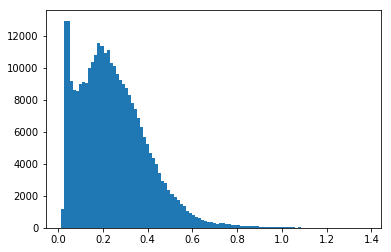

In [20]:
plt.hist(rf_1_preds, bins=100)

(array([1.5870e+03, 1.3376e+04, 1.2750e+04, 9.2320e+03, 8.3530e+03,
        8.4690e+03, 8.8630e+03, 9.0190e+03, 9.2280e+03, 9.6400e+03,
        1.0694e+04, 1.1263e+04, 1.1316e+04, 1.1134e+04, 1.0975e+04,
        1.0858e+04, 1.0422e+04, 1.0179e+04, 9.8230e+03, 9.4140e+03,
        9.1450e+03, 8.6290e+03, 8.5950e+03, 7.9230e+03, 7.3820e+03,
        6.8210e+03, 6.2700e+03, 5.5620e+03, 5.2740e+03, 4.7390e+03,
        4.3300e+03, 3.9100e+03, 3.5000e+03, 3.0190e+03, 2.6320e+03,
        2.3020e+03, 2.1520e+03, 1.9070e+03, 1.7510e+03, 1.5100e+03,
        1.2710e+03, 1.0990e+03, 9.3100e+02, 7.2900e+02, 5.9500e+02,
        4.9800e+02, 4.7000e+02, 4.2600e+02, 3.6300e+02, 3.3700e+02,
        3.6000e+02, 2.8300e+02, 2.8600e+02, 2.4400e+02, 2.3100e+02,
        1.8400e+02, 1.6700e+02, 1.3600e+02, 1.5400e+02, 1.4900e+02,
        1.2600e+02, 1.3800e+02, 1.0700e+02, 8.7000e+01, 7.0000e+01,
        6.4000e+01, 6.9000e+01, 5.3000e+01, 4.4000e+01, 4.1000e+01,
        3.3000e+01, 2.9000e+01, 3.3000e+01, 3.40

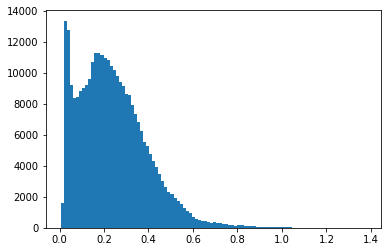

In [48]:
plt.hist(rf_2_preds, bins=100)

# Temperature Scale

In [7]:
rf_t_scale = RandomForestRegressor(n_estimators=50, max_features="sqrt", n_jobs=4)
rf_t_scale.fit(train_data[input_cols], train_data["temperature scale_surface_K"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [8]:
rf_t_scale_preds = rf_t_scale.predict(test_data[input_cols])

In [9]:
def partial_dependence_actual(x, model, x_index, x_bins):
    x_copy = np.copy(x)
    partial_vals = np.zeros(x_bins.shape)
    for b, x_val in enumerate(x_bins):
        x_copy[:, x_index] = x_val
        partial_vals[b] = model.predict(x_copy).mean()
    return partial_vals

In [10]:
pd_bins_t_2 = np.zeros((len(input_cols), 20))
pd_vals_t_2 = np.zeros((len(input_cols), 20))
for i, input_col in enumerate(input_cols):
    print(input_col)
    pd_bins_t_2[i] = np.linspace(test_data[input_col].min(), test_data[input_col].max(), 20)
    pd_vals_t_2[i] = partial_dependence_actual(test_data[input_cols].values, rf_t_scale,
                                               i, pd_bins_t_2[i])

global horizontal irradiance_0 m_W m-2
zenith_0 m_degrees
azimuth_0 m_degrees
pressure_2 m_hPa
potential temperature_10 m_K
potential temperature_2 m_K
mixing ratio_10 m_g kg-1
relative humidity_10 m_%
air density_10 m_kg m-3
wind speed_10 m_m s-1
wind speed_20 m_m s-1
wind speed_40 m_m s-1
mixing ratio_2 m_g kg-1
relative humidity_2 m_%
bulk richardson_10-2 m_


In [59]:
pd_bins_t = np.zeros((len(input_cols), 20))
pd_vals_t = np.zeros((len(input_cols), 19))
pd_vals_t_true = np.zeros((len(input_cols), 19))
pd_min_t = np.zeros((len(input_cols), 19))
pd_max_t = np.zeros((len(input_cols), 19))

pd_counts_t = np.zeros((len(input_cols), 19))
for i, input_col in enumerate(input_cols):
    print(input_col)
    pd_bins_t[i] = np.linspace(test_data[input_col].min(), test_data[input_col].max(), 20)
    pd_vals_t[i], pd_counts_t[i] = partial_dependence_1d(test_data[input_cols].values, 
                                  rf_t_scale_preds, i, pd_bins[i])
    pd_vals_t_true[i], _ = partial_dependence_1d(test_data[input_cols].values,
                                                test_data["temperature scale_surface_K"].values,
                                                i, pd_bins[i])
    pd_min_t[i], pd_counts_t[i] = partial_dependence_1d(test_data[input_cols].values, 
                                  rf_t_scale_preds, i, pd_bins[i], dependence_function=np.min)
    pd_max_t[i], pd_counts_t[i] = partial_dependence_1d(test_data[input_cols].values, 
                                  rf_t_scale_preds, i, pd_bins[i], dependence_function=np.max)

global horizontal irradiance_0 m_W m-2
zenith_0 m_degrees
azimuth_0 m_degrees
pressure_2 m_hPa
potential temperature_10 m_K
potential temperature_2 m_K
mixing ratio_10 m_g kg-1
relative humidity_10 m_%
air density_10 m_kg m-3
wind speed_10 m_m s-1
wind direction_10 m_m s-1
wind speed_20 m_m s-1
wind direction_20 m_m s-1
wind speed_40 m_m s-1
wind direction_40 m_m s-1
u wind_10 m_m s-1
v wind_10 m_m s-1
u wind_20 m_m s-1
v wind_20 m_m s-1
u wind_40 m_m s-1
v wind_40 m_m s-1
mixing ratio_2 m_g kg-1
relative humidity_2 m_%
bulk richardson_10-2 m_
log wind speed_10 m_m s-1


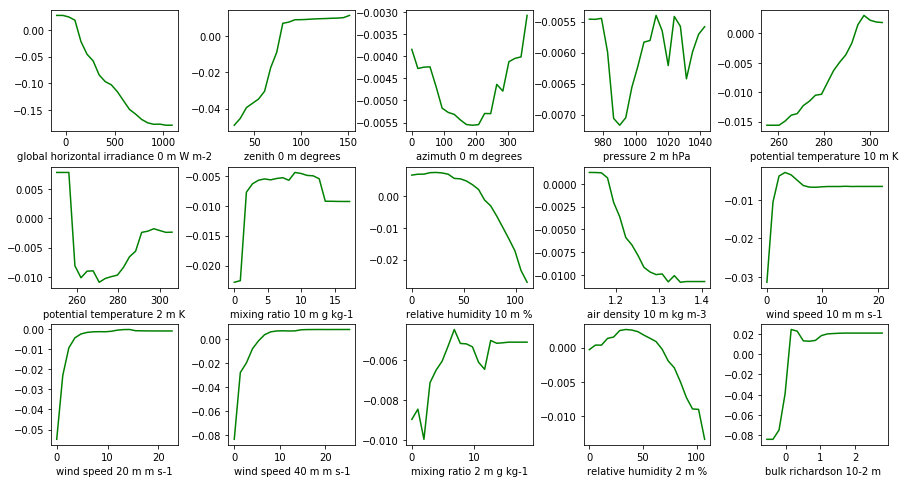

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(15, 8), sharey=False)
plt.subplots_adjust(hspace=0.3, wspace=0.4)
for a, ax in enumerate(axes.ravel()):
    #ax.fill_between(pd_bins_t[a, :-1], pd_max_t[a], pd_min_t[a], alpha=0.3, color="r")
    #ax.plot(pd_bins_t[a,:-1], pd_vals_t[a], color='r')
    #ax.plot(pd_bins_t[a,:-1], pd_vals_t_true[a], color='b')
    ax.plot(pd_bins_t_2[a], pd_vals_t_2[a], color="g")
    #ax.plot(pd_bins_t[a,:-1], pd_counts_t[a] / pd_counts_t[a].sum())
    ax.set_xlabel(input_cols[a].replace("_", " "), fontsize=10)
plt.savefig("pdp_t_scale.png", dpi=200, bbox_inches="tight")

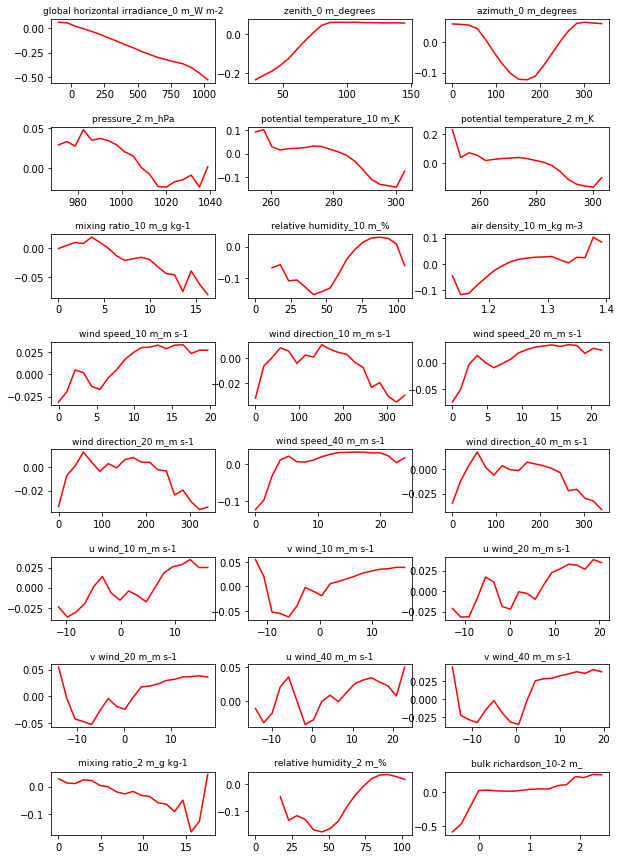

In [95]:
fig, axes = plt.subplots(8, 3, figsize=(10, 15), sharey=False)
plt.subplots_adjust(hspace=0.7, wspace=0.2)
for a, ax in enumerate(axes.ravel()):
    #ax.fill_between(pd_bins_t[a, :-1], pd_max_t[a], pd_min_t[a], alpha=0.3, color="r")
    ax.plot(pd_bins_t[a,:-1], pd_vals_t[a], color='r')
    #ax.plot(pd_bins_t[a,:-1], pd_counts_t[a] / pd_counts_t[a].sum())
    ax.set_title(input_cols[a], fontsize=9)
plt.savefig("cap_t_scale.png", dpi=200, bbox_inches="tight")

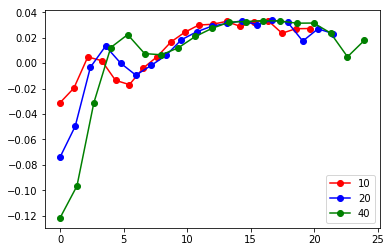

In [58]:
label = [10, 20, 40]
colors = ["red", "blue", "green"]
a = 0
for i in [9, 11, 13]:
    #plt.fill_between(pd_bins_t[i, :-1], pd_max_t[i], pd_min_t[i], alpha=0.2, color=colors[a])
    plt.plot(pd_bins_t[i, :-1], pd_vals_t[i], label=label[a], marker='o', color=colors[a])
    a += 1
plt.legend()

In [24]:
scaler = StandardScaler()
scaled_train_input = scaler.fit_transform(train_data[input_cols])

In [25]:

ann_t_scale = MLPRegressor(hidden_layer_sizes=(32, 64, 128, 256), early_stopping=True, verbose=1)
ann_t_scale.fit(scaled_train_input, train_data["temperature scale_surface_K"])

Iteration 1, loss = 0.00286207
Validation score: 0.751666
Iteration 2, loss = 0.00256528
Validation score: 0.754186
Iteration 3, loss = 0.00251374
Validation score: 0.760485
Iteration 4, loss = 0.00247811
Validation score: 0.760718
Iteration 5, loss = 0.00245333
Validation score: 0.759321
Iteration 6, loss = 0.00243142
Validation score: 0.768806
Iteration 7, loss = 0.00239517
Validation score: 0.769036
Iteration 8, loss = 0.00237492
Validation score: 0.758713
Iteration 9, loss = 0.00235264
Validation score: 0.769871
Iteration 10, loss = 0.00232659
Validation score: 0.768241
Iteration 11, loss = 0.00234685
Validation score: 0.773287
Iteration 12, loss = 0.00235369
Validation score: 0.774322
Iteration 13, loss = 0.00235981
Validation score: 0.770106
Iteration 14, loss = 0.00232544
Validation score: 0.772869
Iteration 15, loss = 0.00232758
Validation score: 0.773686
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(32, 64, 128, 256), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=1, warm_start=False)

In [26]:
ann_t_scale_preds = ann_t_scale.predict(scaler.transform(test_data[input_cols]))

0.02777888066896674
0.027802848562203244
0.8209066985110266
0.8285484476415019


/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


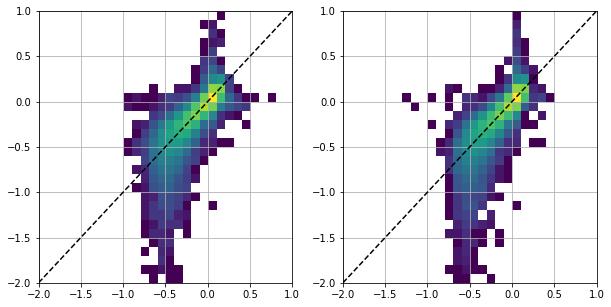

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist2d(rf_t_scale_preds, test_data["temperature scale_surface_K"], cmin=1, bins=np.linspace(-2, 1, 31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.grid()
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.subplot(1, 2, 2)
plt.hist2d(ann_t_scale_preds, test_data["temperature scale_surface_K"], cmin=1, bins=np.linspace(-2, 1, 31), norm=LogNorm())
plt.grid()
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
print(mean_absolute_error(test_data["temperature scale_surface_K"], rf_t_scale_preds))
print(mean_absolute_error(test_data["temperature scale_surface_K"], ann_t_scale_preds))

print(r2_score(test_data["temperature scale_surface_K"], rf_t_scale_preds))
print(r2_score(test_data["temperature scale_surface_K"], ann_t_scale_preds))

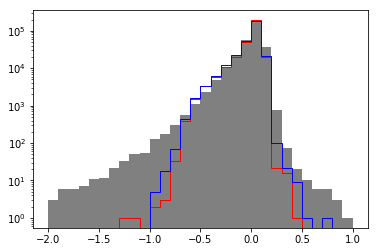

In [30]:
dist_bins = np.linspace(-2, 1, 31)
plt.hist(test_data["temperature scale_surface_K"], bins=dist_bins, color="gray")
plt.hist(ann_t_scale_preds, bins=dist_bins, histtype="step", color="red")
plt.hist(rf_t_scale_preds, bins=dist_bins, histtype="step", color="blue")
plt.gca().set_yscale("log")

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


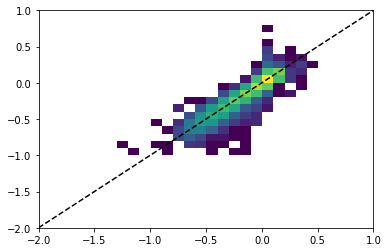

In [31]:
_ = plt.hist2d(ann_t_scale_preds, rf_t_scale_preds, bins=dist_bins, cmin=1, norm=LogNorm())
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')

In [32]:
rf_t_rankings = np.argsort(rf_t_scale.feature_importances_)[::-1]
for f in rf_t_rankings:
    print(input_cols[f], rf_t_scale.feature_importances_[f])

bulk richardson_10-2 m_ 0.23717220288051352
global horizontal irradiance_0 m_W m-2 0.21076444348021856
zenith_0 m_degrees 0.1467336517969053
relative humidity_2 m_% 0.04386384952609882
wind speed_40 m_m s-1 0.042559979998271234
relative humidity_10 m_% 0.028485301941274882
azimuth_0 m_degrees 0.028166648512449998
log wind speed_10 m_m s-1 0.025181891551445595
wind speed_20 m_m s-1 0.024399055223394382
potential temperature_2 m_K 0.022356180185186533
wind speed_10 m_m s-1 0.020126935033596197
potential temperature_10 m_K 0.016511402742232374
u wind_40 m_m s-1 0.014716381619856032
v wind_40 m_m s-1 0.014059587825284919
mixing ratio_2 m_g kg-1 0.013256654752340108
air density_10 m_kg m-3 0.013058599672216316
u wind_20 m_m s-1 0.01251764427731163
pressure_2 m_hPa 0.012405998861460614
u wind_10 m_m s-1 0.012294199982696772
v wind_10 m_m s-1 0.011586049012451742
mixing ratio_10 m_g kg-1 0.011437984478083868
v wind_20 m_m s-1 0.010164605239127428
wind direction_20 m_m s-1 0.009819251604466239

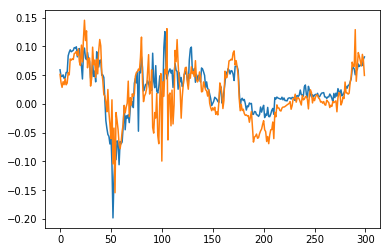

In [33]:
plt.plot(rf_t_scale_preds[300:600])
plt.plot(test_data["temperature scale_surface_K"].values[300:600])

In [89]:
t_scale_class = RandomForestClassifier(n_estimators=50, n_jobs=4, max_features="sqrt", class_weight="balanced")
t_scale_class.fit(train_data[input_cols], np.where(train_data["temperature scale_surface_K"] >= 0, 1, -1))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [90]:
t_scale_sign_preds = t_scale_class.predict(test_data[input_cols])

In [91]:
test_sign_labels = np.where(test_data["temperature scale_surface_K"] >= 0, 1, -1)
confusion_matrix(test_sign_labels, t_scale_sign_preds)

array([[ 85650,  14184],
       [ 10040, 194073]])

In [92]:
confusion_matrix(test_sign_labels, np.where(rf_t_scale_preds >= 0, 1, -1))

array([[ 87090,  12744],
       [ 12268, 191845]])

In [96]:
t_scale_neg_reg = RandomForestRegressor(n_estimators=50, n_jobs=4, max_features="sqrt")
neg_t_scale = train_data["temperature scale_surface_K"] < 0
t_scale_neg_reg.fit(train_data.loc[neg_t_scale, input_cols], 
                    np.log(-train_data.loc[neg_t_scale, "temperature scale_surface_K"]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [97]:
t_scale_pos_reg = RandomForestRegressor(n_estimators=50, n_jobs=4, max_features="sqrt")
pos_t_scale = train_data["temperature scale_surface_K"] > 0
t_scale_pos_reg.fit(train_data.loc[pos_t_scale, input_cols], 
                    np.log(train_data.loc[pos_t_scale, "temperature scale_surface_K"]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [98]:
t_scale_pos_preds = t_scale_pos_reg.predict(test_data[input_cols])
t_scale_neg_preds = t_scale_neg_reg.predict(test_data[input_cols])

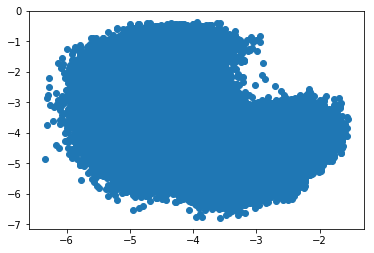

In [99]:
plt.scatter(t_scale_pos_preds, t_scale_neg_preds)

In [100]:
t_scale_combined_preds = np.where(t_scale_sign_preds > 0, np.exp(t_scale_pos_preds), -np.exp(t_scale_neg_preds))

Text(0.5,0,'MAE: 0.0280 R$^2$: 0.820')

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


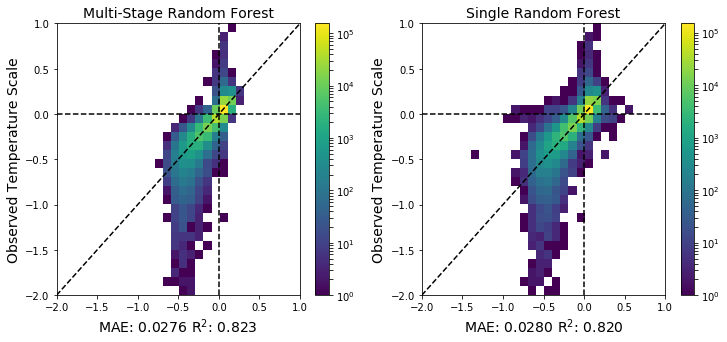

In [132]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(t_scale_combined_preds, test_data["temperature scale_surface_K"], cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')
plt.colorbar()
plt.title("Multi-Stage Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
mae_rf_multi = mean_absolute_error(test_data["temperature scale_surface_K"], t_scale_combined_preds)
r2_rf_multi = r2_score(test_data["temperature scale_surface_K"], t_scale_combined_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_multi, r2_rf_multi), fontsize=14)
plt.subplot(1, 2, 2)
plt.hist2d(rf_t_scale_preds, test_data["temperature scale_surface_K"], cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')

plt.title("Single Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
plt.colorbar()

mae_rf_single = mean_absolute_error(test_data["temperature scale_surface_K"], rf_t_scale_preds)
r2_rf_single = r2_score(test_data["temperature scale_surface_K"], rf_t_scale_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_single, r2_rf_single), fontsize=14)

In [39]:
from keras.layers import Input, Dense, Activation, Multiply, Concatenate, Layer, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as kb

In [11]:
class Sum(Layer):
    def __init__(self, **kwargs):
        super(Sum, self).__init__(**kwargs)
        
    def call(self, x):
        return kb.sum(x)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)
    
class Round(Layer):
    def __init__(self, **kwargs):
        super(Round, self).__init__(**kwargs)
        
    def call(self, x):
        return kb.round(x)
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [243]:
l_in = kb.placeholder()
d = Round()(l_in)
r_func = kb.function([l_in], [d])
r_func([np.array([0.5, 0.8, 0.2])])

[array([0., 1., 0.], dtype=float32)]

In [40]:
dnn_input = Input(shape=(len(input_cols),))
dense_1 = Dense(64, activation="relu")(dnn_input)
dense_1 = BatchNormalization()(dense_1)
dense_2 = Dense(64, activation="relu")(dense_1)
dense_2 = BatchNormalization()(dense_2)
sign_dense = Dense(2, activation="softmax")(dense_2)
pos_dense_1 = Dense(64, activation="relu")(dense_2)
pos_dense_1 = BatchNormalization()(pos_dense_1)
pos_dense_2 = Dense(64, activation="relu")(pos_dense_1)
pos_dense_2 = BatchNormalization()(pos_dense_2)
pos_out = Dense(1)(pos_dense_2)
mod = Model(dnn_input, [sign_dense, pos_out])
mod.compile(optimizer=Adam(lr=0.0001,beta_1=0.6), loss=["categorical_crossentropy", "mae"])

In [41]:
scale_signs = np.zeros((train_data["temperature scale_surface_K"].shape[0], 2))
scale_signs[train_data["temperature scale_surface_K"] < 0, 0] = 1
scale_signs[train_data["temperature scale_surface_K"] > 0, 1] = 1
transformed_scale_data = np.zeros(train_data["temperature scale_surface_K"].shape[0])
pos_out = train_data["temperature scale_surface_K"] > 0
transformed_scale_data[pos_out] = np.log10(train_data["temperature scale_surface_K"][pos_out])
transformed_scale_data[~pos_out] = np.log10(-train_data["temperature scale_surface_K"][~pos_out])
mod.fit(scaled_train_input, [scale_signs, transformed_scale_data], batch_size=256,
        epochs=15)

Epoch 1/15
352612/352612 [==============================] - 7s 19us/step - loss: 0.9825 - dense_37_loss: 0.3449 - dense_40_loss: 0.6376
Epoch 2/15
352612/352612 [==============================] - 5s 15us/step - loss: 0.5007 - dense_37_loss: 0.2307 - dense_40_loss: 0.2700
Epoch 3/15
352612/352612 [==============================] - 5s 15us/step - loss: 0.4698 - dense_37_loss: 0.2208 - dense_40_loss: 0.2490
Epoch 4/15
352612/352612 [==============================] - 5s 15us/step - loss: 0.4544 - dense_37_loss: 0.2159 - dense_40_loss: 0.2385
Epoch 5/15
352612/352612 [==============================] - 5s 15us/step - loss: 0.4452 - dense_37_loss: 0.2131 - dense_40_loss: 0.2322
Epoch 6/15
352612/352612 [==============================] - 5s 15us/step - loss: 0.4386 - dense_37_loss: 0.2106 - dense_40_loss: 0.2280
Epoch 7/15
352612/352612 [==============================] - 5s 15us/step - loss: 0.4330 - dense_37_loss: 0.2080 - dense_40_loss: 0.2250
Epoch 8/15
352612/352612 [======================

In [42]:
test_sign_probs, nn_scale_preds = mod.predict(scaler.transform(test_data[input_cols]))
print(nn_scale_preds.shape)

(303947, 1)


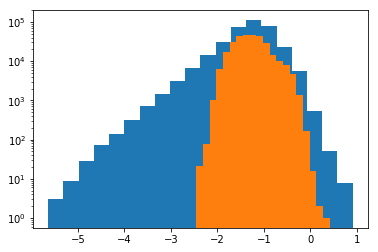

In [108]:
plt.hist(transformed_scale_data, bins=20)
plt.hist(nn_scale_preds, bins=20)
plt.gca().set_yscale("log")

In [44]:
test_scale_signs = np.zeros((test_data["temperature scale_surface_K"].shape[0], 2))
test_scale_signs[test_data["temperature scale_surface_K"] < 0, 0] = 1
test_scale_signs[test_data["temperature scale_surface_K"] > 0, 1] = 1

In [45]:
confusion_matrix(test_scale_signs.argmax(axis=1), test_sign_probs.argmax(axis=1))

array([[ 82904,  16930],
       [  7139, 196974]])

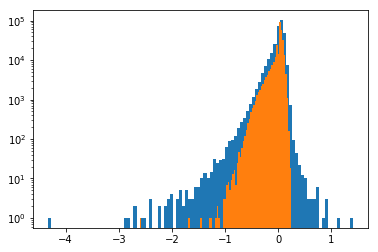

In [49]:
test_preds = np.where(test_sign_probs.argmax(axis=1) == 1,1, -1) * 10 ** nn_scale_preds.ravel()
plt.hist(test_data["temperature scale_surface_K"], bins=100)
plt.hist(test_preds, bins=100)

plt.gca().set_yscale("log")

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


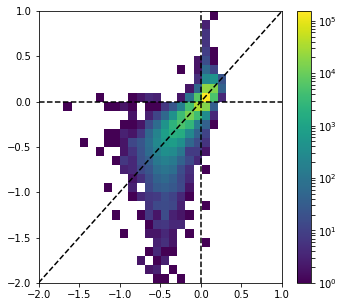

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(test_preds, test_data["temperature scale_surface_K"], cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')
plt.colorbar()

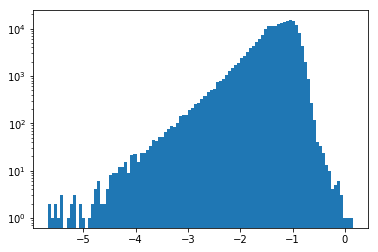

In [203]:
plt.hist(np.log10(test_data["temperature scale_surface_K"][test_data["temperature scale_surface_K"] > 0]), bins=100)
plt.gca().set_yscale("log")

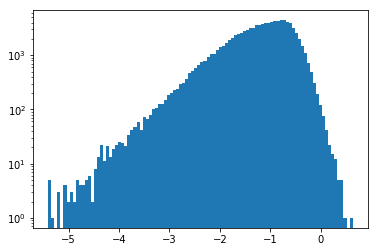

In [202]:
plt.hist(np.log10(-test_data["temperature scale_surface_K"][test_data["temperature scale_surface_K"] < 0]), bins=100)
plt.gca().set_yscale("log")

In [199]:
np.count_nonzero(test_data["temperature scale_surface_K"] == 0)

0

NameError: name 'test_preds' is not defined

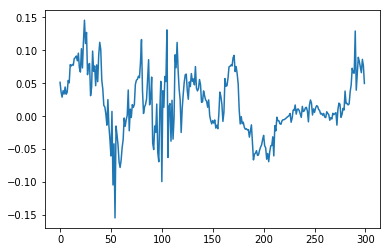

In [34]:
plt.plot(test_data["temperature scale_surface_K"][300:600].values)
plt.plot(test_preds.ravel()[300:600])

In [57]:
test_data["temperature scale_surface_K"].idxmax()

Timestamp('2011-07-15 20:50:00')

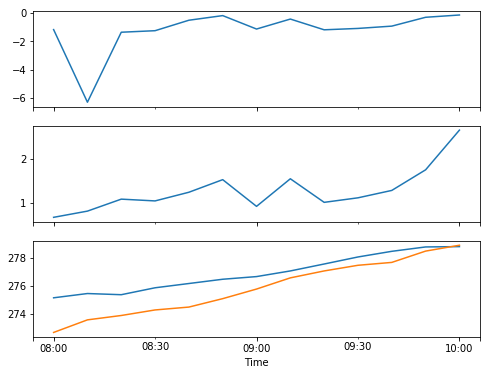

In [92]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6),sharex=True)
train_data.loc['2005-11-14 08:00:00':'2005-11-14 10:00:00', "temperature scale_surface_K"].plot(ax=axes[0])
train_data.loc['2005-11-14 08:00:00':'2005-11-14 10:00:00', 'wind speed_10 m_m s-1'].plot(ax=axes[1])
train_data.loc['2005-11-14 08:00:00':'2005-11-14 10:00:00', 'potential temperature_10 m_K'].plot(ax=axes[2])
train_data.loc['2005-11-14 08:00:00':'2005-11-14 10:00:00', 'potential temperature_2 m_K'].plot(ax=axes[2])

In [61]:
test_data.columns

Index(['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees', 'temperature_10 m_K', 'temperature_2 m_K',
       'pressure_2 m_hPa', 'potential temperature_10 m_K',
       'potential temperature_2 m_K', 'mixing ratio_10 m_g kg-1',
       'relative humidity_10 m_%', 'virtual potential temperature_10 m_K',
       'air density_10 m_kg m-3', 'wind speed_10 m_m s-1',
       'wind direction_10 m_m s-1', 'wind speed_20 m_m s-1',
       'wind direction_20 m_m s-1', 'wind speed_40 m_m s-1',
       'wind direction_40 m_m s-1', 'u wind_10 m_m s-1', 'v wind_10 m_m s-1',
       'u wind_20 m_m s-1', 'v wind_20 m_m s-1', 'u wind_40 m_m s-1',
       'v wind_40 m_m s-1', 'mixing ratio_2 m_g kg-1',
       'virtual potential temperature_2 m_K', 'relative humidity_2 m_%',
       'soil temperature_0 cm_K', 'soil temperature_4 cm_K',
       'soil potential temperature_0 cm_K',
       'soil potential temperature_4 cm_K', 'soil water content_3 cm_m3 m-3',
       'soil wat

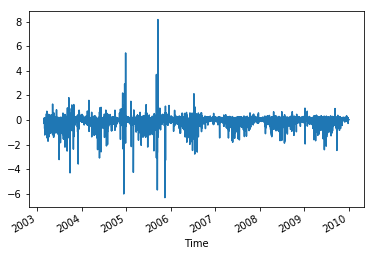

In [74]:
train_data["temperature scale_surface_K"].plot()

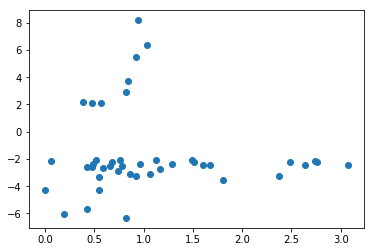

In [97]:
neg_indices = np.abs(train_data["temperature scale_surface_K"]) > 2
plt.scatter(train_data["wind speed_10 m_m s-1"][neg_indices], 
            train_data["temperature scale_surface_K"][neg_indices])

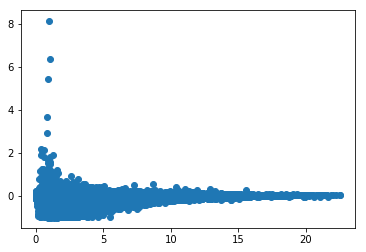

In [95]:
plt.scatter(train_data["wind speed_10 m_m s-1"][~neg_indices], 
            train_data["temperature scale_surface_K"][~neg_indices])

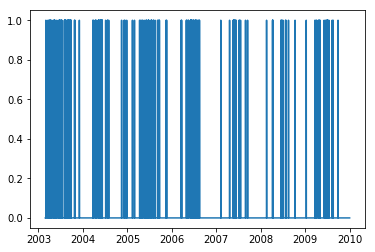

In [76]:
plt.plot(train_data["temperature scale_surface_K"] < -1)

In [79]:
neg_scale = (train_data["temperature scale_surface_K"] < -1).values
runs = np.zeros(neg_scale.shape)
run = 0
for i in range(neg_scale.shape[0]):
    if neg_scale[i] == 0:
        run = 0
    else:
        run += 1
    runs[i] = run

(array([272.,  20.,   4.]), array([1, 2, 3, 4]), <a list of 3 Patch objects>)

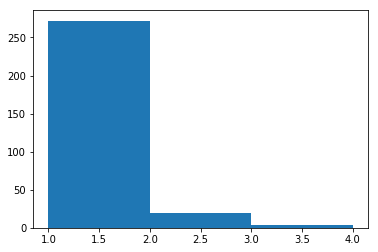

In [82]:
plt.hist(runs, bins=np.arange(1, 5))

In [83]:
runs.argmax()

136651

In [84]:
train_data.index[136651]

Timestamp('2005-11-14 08:30:00')

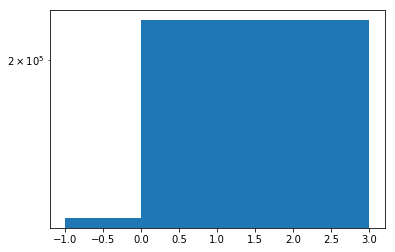

In [101]:
plt.hist(train_data["bulk richardson_10-2 m_"], bins=[-1, 0, 3])
plt.gca().set_yscale("log")

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-0.46001903, -0.43168733, -0.40335563, -0.37502393, -0.34669223,
        -0.31836052, -0.29002882, -0.26169712, -0.23336542, -0.20503372,
        -0.17670202, -0.14837032, -0.12003862, -0.09170692, -0.06337521,
        -0.03504351, -0.00671181,  0.02161989,  0.04995159,  0.07828329,
         0.10661499,  0.13494669,  0.16327839,  0.1916101 ,  0.2199418 ,
         0.2482735 ,  0.2766052 ,  0.3049369 ,  0.3332686 ,  0.3616003 ,
         0.389932  ,  0.4182637 ,  0.44659541,  0.47492711,  0.50325881,
         0.53159051,  0.55992221,  0.58825391,  0.61658561,  0.64491731,
         0.67324901,  0.70158072,  0.72991242,  0.75824412,  0.78657582,
         0.81490752,  0.84323922,  0.87157092,  0.89990262

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


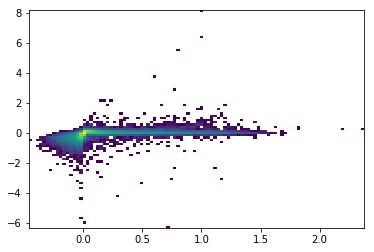

In [104]:
plt.hist2d(train_data["bulk richardson_10-2 m_"], train_data["temperature scale_surface_K"],
           cmin=1, norm=LogNorm(), bins=100)

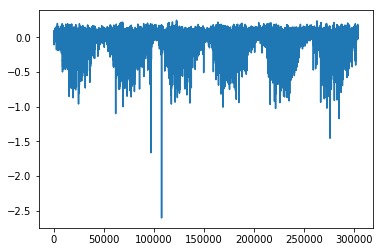

In [107]:
plt.plot(test_preds)

In [7]:
from math import log, atan, sqrt
from numba import jit
@jit(nopython=True)
def mo_similarity(u10, v10, tsk, t2, qsfc, q2, psfc, z0=0.1, zt0=2, z10=10.0, z2=10.0):
    """
    Calculate flux information based on Monin-Obukhov similarity theory.

    Args:
        u10: 10 m level zonal wind speed [m/s]
        v10: 10 m level meridional wind speed [m/s]
        tsk: surface skin temperature [K]
        t2: 2 m level temperature [K]
        qsfc: ground mixing ratio
        q2: 2 m level mixing ratio
        psfc: surface pressure
        z0: momentum roughness length
        zt0: heat flux roughness length
        z10: Height of "10 m" layer
        z2: Height of "2 m" layer

    Returns:
        ustar: friction velocity
        tstar: temperature scale
        wthv0: -ustar * tstar
        zeta10: z/L for a z of 10 m. Used for momentum flux
        phim10: momentum universal function at 10 m
        zeta2: z/L for a z of 2 m.
        phih2: sensible heat flux universal function at 2 m.
    """
    if z0 > 0:
        z10oz0 = z10 / z0
        z2oz0 = z2 / z0
        z2ozt0 = z2 / zt0
    else:
        raise ValueError("z0 must be greater than 0")
    # else:
    #    sys.exit("Surface roughnes, z0, must be greter than 0.!")
    #
    # Gravitational acceleration
    g = 9.81
    #
    # Gas constant over spcific heat capacity at constant pressure
    r = 287.058
    cp = 1005.
    rocp = r / cp
    #
    # Reference pressure and temperature
    p0 = 1000.
    t0 = 300.
    #
    # Set M-O parameters based on Dyer 1974 paper
    karman = 0.4
    beta = 5.0
    gamma = 16.0
    #
    # Air density
    rho = psfc / (r * t2)
    #
    # Potential temperature speed at level 1
    th2 = t2 * (p0 / psfc) ** rocp
    th0 = tsk * (p0 / psfc) ** rocp
    #
    # Virtual potential temperature
    thv2 = th2 * (1. + 0.61 * q2)
    thv0 = th0 * (1. + 0.61 * qsfc)
    #
    # Small number
    epsilon = 1.e-6
    #
    # Initial values of drag coefficients - neutrally stratified case
    cd = karman ** 2 / ((log(z10oz0)) ** 2)
    ch = karman ** 2 / ((log(z2ozt0)) ** 2)
    cq = karman ** 2 / ((log(z2ozt0)) ** 2)
    #
    # Initial values of surface friction velocity, temperature scale, and
    # heat flux
    wind_speed = sqrt(u10 * u10 + v10 * v10)
    if wind_speed < 0.1:
        wind_speed = 0.1
        u10 = 0.1
    tauxz = cd * wind_speed * u10
    tauyz = cd * wind_speed * v10
    ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25

    tstar = -ch / ustar * wind_speed * (th0 - th2)
    wthv0 = -ustar * tstar
    #
    # Set stopping criterion
    diff = 1.
    #
    # Set stability functions
    psim10 = 0.
    psim2 = 0.
    psih2 = 0.
    psiq2 = 0.
    phim10 = 0.
    phih2 = 0
    #
    zeta10 = 0.
    zeta2 = 0.
    count = 0
    while diff > epsilon and count < 100:
        #
        # Surface friction velocity and temperature scale
        tauxz = cd * wind_speed * u10
        tauyz = cd * wind_speed * v10
        ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25
        if ustar < 0.01:
            ustar = 0.01
        wspd2 = ustar / karman * (log(z2oz0) - psim2)
        tstar = -ch / ustar * wind_speed * (thv0 - thv2)
        wthv0 = -ustar * tstar
        #
        # Compute drag coefficients
        cdold = cd
        chold = ch
        cqold = cq
        #
        # Neutrally stratified case
        if wthv0 == 0:
            zeta10 = 0.
            zeta2 = 0.
            psim10 = 0.
            psim2 = 0.
            psih2 = 0.
            psiq2 = 0.
            phim10 = 1.
            phih2 = 1.
            cd = karman ** 2 / ((log(z10oz0)) ** 2)
            ch = karman ** 2 / ((log(z2ozt0)) ** 2)
            cq = karman ** 2 / ((log(z2ozt0)) ** 2)
        elif abs(wthv0) > 0:
            #
            # Obukhov length scale
            olength = -ustar ** 3 / (karman * g / t0 * wthv0)
            if abs(olength) < 10 and olength > 0:
                olength = z10
            elif abs(olength) < 10 and olength < 0:
                olength = -z10
            #
            # Free convection
            # if (olength == 0.):
            #    sys.exit("Free convection!")
            #
            # Monin-Obukhov stability parameter
            zeta10 = z10 / olength
            zeta2 = z2 / olength
            #
            # Convective case
            if (zeta2 < -epsilon) & (zeta10 >= -2.):
                xi10 = 1. / ((1. - gamma * zeta10) ** 0.25)
                xi2 = 1. / ((1. - gamma * zeta2) ** 0.25)
                psim10 = log(0.5 * (1.0 + xi10 ** 2) * (0.5 * (1.0 + xi10)) ** 2) \
                    - 2. * atan(xi10) + 0.5 * np.pi
                psim2 = log(0.5 * (1.0 + xi2 ** 2) * (0.5 * (1.0 + xi2)) ** 2) \
                    - 2. * atan(xi2) + 0.5 * np.pi
                psih2 = 2.0 * log(0.5 * (1.0 + xi2 ** 2))
                psiq2 = 2.0 * log(0.5 * (1.0 + xi2 ** 2))
                phim10 = 1. / ((1. - gamma * zeta10) ** 0.25)
                phih2 = 1. / ((1. - gamma * zeta2) ** 0.25)
            #
            # Stably stratified case
            elif (zeta2 > epsilon) & (zeta2 <= 1.):
                psim10 = - beta * zeta10
                psim2 = - beta * zeta2
                psih2 = - beta * zeta2
                psiq2 = - beta * zeta2
                phim10 = (1. + beta * zeta10)
                phih2 = (1. + beta * zeta2)
            #
            # Neutrally stratified case
            elif (zeta2 <= epsilon) & (zeta2 >= -epsilon):
                psim10 = 0.
                psim2 = 0.
                psih2 = 0.
                psiq2 = 0.
                phim10 = 1.
                phih2 = 1.
            #
            cd = karman ** 2 / ((log(z10oz0) - psim10) ** 2)
            ch = karman ** 2 / ((log(z2ozt0) - psim2) * (log(z2ozt0) - psih2))
            cq = karman ** 2 / ((log(z2ozt0) - psim2) * (log(z2ozt0) - psiq2))
        #
        diff = abs(cd - cdold) + abs(ch - chold) + abs(cq - cqold)
        count += 1
    #
    return ustar, tstar, wthv0, zeta10, phim10, zeta2, phih2

In [8]:
@jit(nopython=False)
def calc_mo_values(in_data):
    mo_values = pd.DataFrame(0, index=in_data.index, 
                         columns=["friction velocity_surface_m s-1", "temperature scale_surface_K", 'wthv0', 'zeta10', 'phim10', 'zeta2', 'phih2'],
                        dtype=float)
    for i, date in enumerate(in_data.index):
        if i % 1000 == 0:
            print(date)
        mo_values.loc[date] = mo_similarity(in_data.loc[date, "u wind_10 m_m s-1"], 
                                            in_data.loc[date, "v wind_10 m_m s-1"], 
                      in_data.loc[date, "temperature_2 m_K"],
                      in_data.loc[date,"temperature_10 m_K"], 
                      in_data.loc[date, "mixing ratio_2 m_g kg-1"] / 1000, 
                      in_data.loc[date,"mixing ratio_10 m_g kg-1"] / 1000,
                      in_data.loc[date,"pressure_2 m_hPa"],
                      z0=0.1,
                      zt0=2)
    return mo_values
mo_values = calc_mo_values(test_data)

2011-01-01 00:00:00
2011-01-07 22:40:00
2011-01-14 21:20:00
2011-01-21 20:00:00
2011-01-28 18:40:00
2011-02-04 17:20:00
2011-02-11 16:00:00
2011-02-18 15:50:00
2011-02-25 14:30:00
2011-03-04 13:10:00
2011-03-11 11:50:00
2011-03-18 10:30:00
2011-03-25 09:10:00
2011-04-01 07:50:00
2011-04-08 06:40:00
2011-04-15 05:20:00
2011-04-22 04:00:00
2011-04-29 02:40:00
2011-05-06 01:40:00
2011-05-13 00:20:00
2011-05-19 23:10:00
2011-05-26 21:50:00
2011-06-02 20:30:00
2011-06-09 19:10:00
2011-06-16 17:50:00
2011-06-23 16:30:00
2011-06-30 15:10:00
2011-07-07 13:50:00
2011-07-14 12:30:00
2011-07-21 11:10:00
2011-07-28 09:50:00
2011-08-04 08:30:00
2011-08-11 07:10:00
2011-08-18 05:50:00
2011-08-25 04:30:00
2011-09-01 08:50:00
2011-09-08 07:30:00
2011-09-15 06:10:00
2011-09-22 04:50:00
2011-09-29 03:30:00
2011-10-06 02:10:00
2011-10-13 00:50:00
2011-10-19 23:30:00
2011-10-26 22:10:00
2011-11-02 20:50:00
2011-11-09 19:30:00
2011-11-16 18:10:00
2011-11-23 16:50:00
2011-11-30 15:30:00
2011-12-07 14:10:00


(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-1.81920484, -1.76996228, -1.72071972, -1.67147716, -1.6222346 ,
        -1.57299204, -1.52374948, -1.47450692, -1.42526436, -1.3760218 ,
        -1.32677924, -1.27753668, -1.22829412, -1.17905157, -1.12980901,
        -1.08056645, -1.03132389, -0.98208133, -0.93283877, -0.88359621,
        -0.83435365, -0.78511109, -0.73586853, -0.68662597, -0.63738341,
        -0.58814085, -0.53889829, -0.48965573, -0.44041317, -0.39117061,
        -0.34192805, -0.29268549, -0.24344293, -0.19420037, -0.14495781,
        -0.09571525, -0.04647269,  0.00276987,  0.05201243,  0.10125499,
         0.15049754,  0.1997401 ,  0.24898266,  0.29822522,  0.34746778,
         0.39671034,  0.4459529 ,  0.49519546,  0.54443802

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


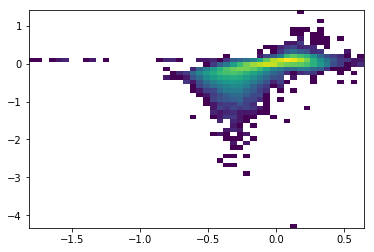

In [9]:
plt.hist2d(mo_values["temperature scale_surface_K"], 
           test_data["temperature scale_surface_K"], cmin=1, norm=LogNorm(), bins=50)


In [10]:
np.corrcoef(mo_values["temperature scale_surface_K"], 
           test_data["temperature scale_surface_K"])

array([[1.        , 0.76632847],
       [0.76632847, 1.        ]])

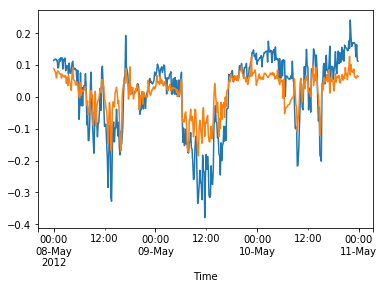

In [22]:
(mo_values.loc["2012-05-08":"2012-05-10", "temperature scale_surface_K"]).plot()
(test_data.loc["2012-05-08":"2012-05-10", "temperature scale_surface_K"]).plot()

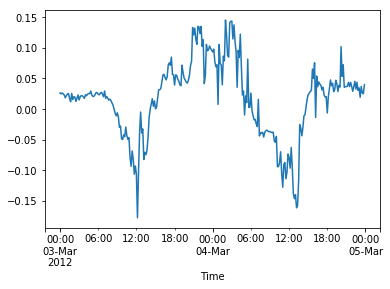

In [44]:
test_data.loc["2012-03-03":"2012-03-04", "temperature scale_surface_K"].plot()

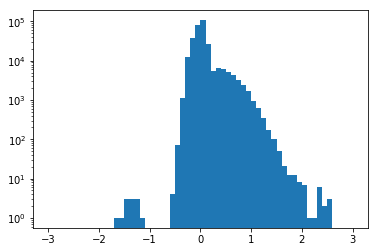

In [106]:
plt.hist(mo_values["temperature scale_surface_K"], bins=np.linspace(-3, 3, 61))
#plt.hist(test_data["temperature scale_surface_K"], bins=np.linspace(-3, 3, 61))
plt.gca().set_yscale("log")

In [172]:
mo_values["tstar"]

Time
2010-01-01 00:00:00    0.018289
2010-01-01 00:10:00    0.019138
2010-01-01 00:20:00    0.019146
2010-01-01 00:30:00    0.018295
2010-01-01 00:40:00    0.018299
2010-01-01 00:50:00    0.019102
2010-01-01 01:00:00    0.019093
2010-01-01 01:10:00    0.019100
2010-01-01 01:20:00    0.018322
2010-01-01 01:30:00    0.018359
2010-01-01 01:40:00    0.018279
2010-01-01 01:50:00    0.018187
2010-01-01 02:00:00    0.019101
2010-01-01 02:10:00   -0.002394
2010-01-01 02:20:00    0.019099
2010-01-01 02:30:00    0.019093
2010-01-01 02:40:00    0.019948
2010-01-01 02:50:00   -0.001618
2010-01-01 03:00:00   -0.000749
2010-01-01 03:10:00    0.018256
2010-01-01 03:20:00    0.019104
2010-01-01 03:30:00    0.018281
2010-01-01 03:40:00    0.018237
2010-01-01 03:50:00    0.019073
2010-01-01 04:00:00    0.019109
2010-01-01 04:10:00    0.018302
2010-01-01 04:20:00    0.018337
2010-01-01 04:30:00    0.018345
2010-01-01 04:40:00    0.019145
2010-01-01 04:50:00    0.018342
                         ...   
201

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


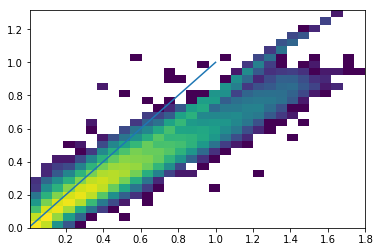

In [12]:
plt.hist2d(mo_values["friction velocity_surface_m s-1"], test_data["friction velocity_surface_m s-1"], cmin=1, norm=LogNorm(), bins=30)
plt.plot(np.linspace(0, 1), np.linspace(0, 1))

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


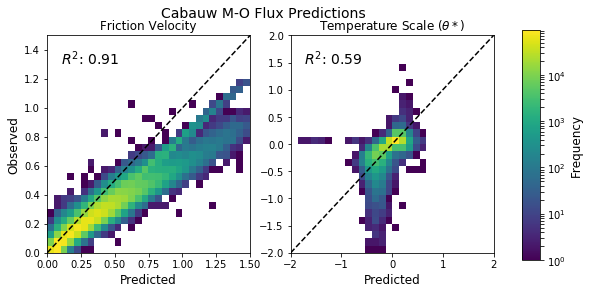

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cax = fig.add_axes([0.95,0.1, 0.03, 0.8])
bins = [np.linspace(0, 1.5, 31),
        np.linspace(-2, 2, 31),
        np.linspace(-4, 4, 30)]
titles = ["Friction Velocity", "Temperature Scale ($\\theta *$)"]
out_cols = ["friction velocity_surface_m s-1", "temperature scale_surface_K"]
val_cols= []
for a, ax in enumerate(axes):
    h_obj = ax.hist2d(mo_values[out_cols[a]], test_data.loc[:, out_cols[a]], cmin=1, bins=bins[a], norm=LogNorm())
    ax.plot(bins[a], bins[a],'k--')
    ax.set_title(titles[a])
    r2 = np.corrcoef(mo_values[out_cols[a]], 
                     test_data.loc[:, out_cols[a]])[0, 1] ** 2
    ax.text(bins[a][2], bins[a][-5], "$R^2$: {0:0.2f}".format(r2),
           fontsize=14)
    if a == 0:
        ax.set_ylabel("Observed", fontsize=12)
    ax.set_xlabel("Predicted", fontsize=12)
cbar = plt.colorbar(h_obj[-1], cax=cax)
cbar.set_label(label="Frequency", fontsize=12)
fig.suptitle("Cabauw M-O Flux Predictions", fontsize=14)
plt.savefig("cabauw_mo_flux_hist.png", dpi=200, bbox_inches="tight")

(array([[2.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00,
                nan,        nan,        nan, 6.0000e+00,        nan,
         1.8000e+01, 2.1000e+02, 4.8000e+02, 8.6600e+02, 4.8800e+03,
         3.8542e+04, 1.4891e+04, 1.2230e+03, 5.8000e+01, 1.4000e+01],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
         1.1000e+01, 8.6000e+01, 2.6800e+02, 5.6200e+02, 1.9260e+03,
         5.7930e+03, 1.6290e+03, 2.9000e+01,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
         2.0000e+01, 1.5100e+02, 4.3800e+02, 9.5100e+02, 3.0630e+03,
         7.7620e+03, 2.1330e+03, 3.7000e+01, 2.0000e+00, 1.0000e+00],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan, 2.0000e+00,
         5.7000e+01, 2.6200e+02

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


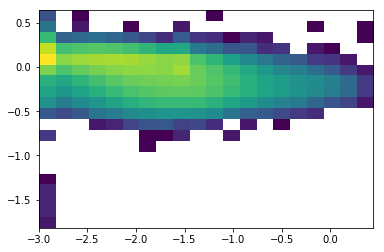

In [14]:
plt.hist2d(np.log10(test_data["roughness length_surface_m"]), mo_values["temperature scale_surface_K"], 
           bins=20, cmin=1, norm=LogNorm())


(array([[2.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00,
                nan,        nan, 1.0000e+00, 8.0000e+00, 4.0000e+00,
         1.2500e+02, 1.3370e+03, 3.5580e+03, 3.3740e+03, 1.4900e+03,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan, 4.0000e+00,
         2.2000e+01, 2.3800e+02, 5.4300e+02, 4.6400e+02, 2.0900e+02,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan, 1.0000e+00,
         4.8000e+01, 3.1600e+02, 6.5500e+02, 5.5700e+02, 2.9300e+02,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan, 1.0000e+00, 2.0000e+00,
         5.2000e+01, 4.6500e+02

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


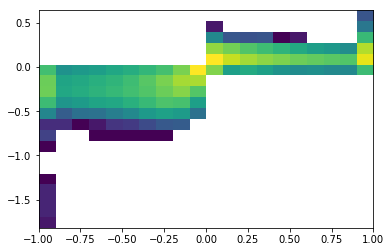

In [17]:
plt.hist2d(mo_values["zeta2"], mo_values["temperature scale_surface_K"], cmin=1, norm=LogNorm(), bins=20
          )

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 5.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00,
        3.0000e+00, 4.0000e+00, 9.0000e+00, 1.8000e+01, 3.9000e+01,
        9.8000e+01, 1.4100e+02, 2.5900e+02, 4.4100e+02, 5.9700e+02,
        8.9700e+02, 1.2580e+03, 1.7220e+03, 2.3110e+03, 2.7150e+03,
        3.4900e+03, 3.9350e+03, 4.1310e+03, 4.9250e+03, 4.8560e+03,
        5.4510e+03, 6.1220e+03, 6.0630e+03, 8.0170e+03, 7.0360e+03,
        9.1820e+03, 1.3149e+04, 5.0730e+03, 2.25

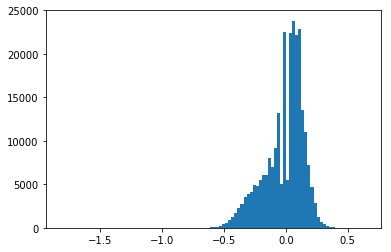

In [19]:
plt.hist(mo_values["temperature scale_surface_K"], bins=100)

In [141]:
test_data["friction velocity_surface_m s-1"].min()

0.001

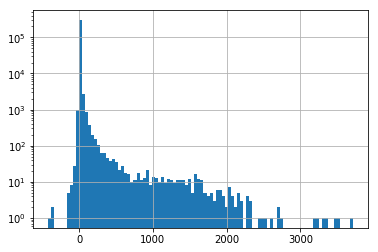

In [21]:
mo_values["zeta2"].hist(bins=100)
plt.gca().set_yscale("log")

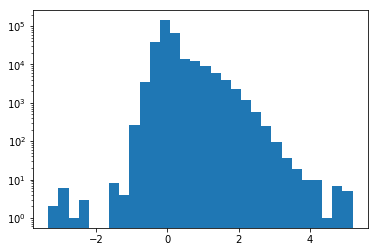

In [28]:
plt.hist(mo_values["temperature scale_surface_K"], bins=30)
plt.gca().set_yscale("log")

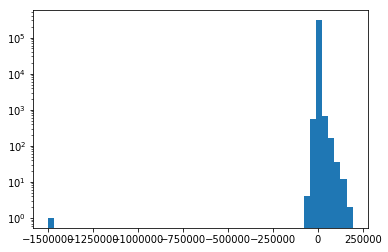

In [37]:
plt.hist(10 / mo_values["zeta2"], bins=50)
plt.gca().set_yscale("log")

In [39]:
np.abs(10 / mo_values["zeta2"]).min()

0.0026952091010566492

In [43]:
10 / 10

1.0